### EDA- Censos Argentina

In [1]:
## Imports

import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from utils import read_table_into_dataframe


In [2]:
### CONNECT TO POSTGRES DATABASE
## AMBA

import psycopg2

# Establish connection parameters
dbname = 'AMBA'
user = 'postgres'
password = 'Ferm1987'
host = 'localhost'  # By default, localhost
port = '5432'  # By default, 5432

# Connect to the PostgreSQL database
try:
    conn = psycopg2.connect(
        dbname=dbname,
        user=user,
        password=password,
        host=host,
        port=port
    )

    # Create a cursor object
    cursor = conn.cursor()

    # Execute a query
    cursor.execute("SELECT version();")
    db_version = cursor.fetchone()
    print("Connected to:", db_version)

    # Commit the transaction
    conn.commit()

except psycopg2.Error as e:
    print("Error connecting to PostgreSQL:", e)

finally:
    # Close the cursor and connection
    if 'cursor' in locals() and cursor is not None:
        cursor.close()
    # if 'conn' in locals() and conn is not None:
    #     conn.close()


Connected to: ('PostgreSQL 16.1, compiled by Visual C++ build 1937, 64-bit',)


In [3]:
# Read poblacion
df = read_table_into_dataframe('public.poblacion')
if df is not None:
    print(df)

      id AñoCenso CodigoDpto            Departamento  Poblacion   Varones  \
0    206     1991       6028         Almirante Brown   450698.0  222042.0   
1    207     1991       6035              Avellaneda   344991.0  164243.0   
2    208     1991       6091             Berazategui   244929.0  120870.0   
3    209     1991       6260  Esteban Echeverría (1)   275793.0  136784.0   
4    210     1991       6270              Ezeiza (2)        NaN       NaN   
..   ...      ...        ...                     ...        ...       ...   
200  406     2022       6756              San Isidro   298777.0  139818.0   
201  407     2022       6760              San Miguel   326215.0  157244.0   
202  408     2022       6805                   Tigre   447785.0  215056.0   
203  409     2022       6840         Tres de Febrero   366377.0  173299.0   
204  410     2022       6861           Vicente López   283510.0  131723.0   

      Mujeres  VivPartTot  VivColectTot  IndMasc  Superficie  DensPob  
0  

In [4]:
# Read vCensosAmba
df = read_table_into_dataframe('public.v_censos_amba')
if df is not None:
    print(df)

                nam cod_depto  anio       pob       var       muj   vivpart  \
0       José C. Paz     06412  2022  323918.0  157631.0  165831.0   97098.0   
1       José C. Paz     06412  2010  265981.0  131291.0  134690.0   72243.0   
2       José C. Paz     06412  2001  230208.0  114134.0  116074.0   59674.0   
3       José C. Paz     06412  1991       NaN       NaN       NaN       NaN   
4     Vicente López     06861  2022  283510.0  131723.0  149903.0  126139.0   
..              ...       ...   ...       ...       ...       ...       ...   
91  Lomas de Zamora     06490  1991  574330.0  278877.0  295453.0       NaN   
92       Avellaneda     06035  2022  370939.0  174572.0  194911.0  144988.0   
93       Avellaneda     06035  2010  342677.0  162264.0  180413.0  121307.0   
94       Avellaneda     06035  2001  328980.0  155450.0  173530.0  117200.0   
95       Avellaneda     06035  1991  344991.0  164243.0  180748.0       NaN   

    vivtotal  Superficie     sup ind_masc dens_pob 

In [ ]:
df.describe()
df.shape
df.columns
df.dtypes
df.info()
df.isnull().sum()


In [5]:
numeric_features=[feature for feature in df.columns if df[feature].dtype !='O']

categorical_features=[feature for feature in df.columns if df[feature].dtype =='O']
print(f" We have {len(numeric_features)} number of numerical features ",numeric_features)
print(f" We have {len(categorical_features)} number of Categorical features ",categorical_features)

 We have 6 number of numerical features  ['pob', 'var', 'muj', 'vivpart', 'vivtotal', 'Superficie']
 We have 6 number of Categorical features  ['nam', 'cod_depto', 'anio', 'sup', 'ind_masc', 'dens_pob']


In [6]:
## NAN VALUES
nan_values = df.isna().sum()
print(nan_values)

## Fill NAN values with none
df_filled = df.fillna(0)     ## Specific columm -->##{'pob': 0}
nan_values = df_filled.isna().sum()
print(nan_values)
df=df_filled



# df_filled = df.fillna({'pob': 0})
# nan_values = df_filled.isna().sum()
# print(nan_values)
# df=df_filled

nam            0
cod_depto      0
anio           0
pob            6
var            6
muj            6
vivpart       24
vivtotal      24
Superficie    78
sup            0
ind_masc       6
dens_pob       6
dtype: int64
nam           0
cod_depto     0
anio          0
pob           0
var           0
muj           0
vivpart       0
vivtotal      0
Superficie    0
sup           0
ind_masc      0
dens_pob      0
dtype: int64


In [7]:
# import custom fucntions
from utils import categorize_dens_pob
from utils import categorize_sup

# Apply the function to create a new column
df['sup_category'] = df['sup'].apply(categorize_sup)
df_cleaned = df.dropna(subset=['dens_pob'])
df=df_cleaned
df['dens_category'] = df['dens_pob'].apply(categorize_dens_pob)
df = df.sort_values(by='anio')
# Check the DataFrame after categorizing
print(df)


                 nam cod_depto  anio       pob       var       muj   vivpart  \
47        San Miguel     06760  1991       0.0       0.0       0.0       0.0   
27             Tigre     06805  1991  257922.0  127987.0  129935.0       0.0   
31            Ezeiza     06270  1991       0.0       0.0       0.0       0.0   
35   Almirante Brown     06028  1991  450698.0  222042.0  228656.0       0.0   
39             Merlo     06539  1991  390858.0  193521.0  197337.0       0.0   
..               ...       ...   ...       ...       ...       ...       ...   
8             Moreno     06560  2022  574374.0  280118.0  293251.0  185037.0   
64        San Isidro     06756  2022  298777.0  139818.0  157584.0  121246.0   
68         Ituzaingó     06410  2022  179788.0   84855.0   92708.0   64175.0   
76  Florencio Varela     06274  2022  497818.0  239305.0  250192.0  145546.0   
0        José C. Paz     06412  2022  323918.0  157631.0  165831.0   97098.0   

    vivtotal  Superficie     sup ind_ma

                nam cod_depto  anio       pob       var       muj  vivpart  \
47       San Miguel     06760  1991       0.0       0.0       0.0      0.0   
27            Tigre     06805  1991  257922.0  127987.0  129935.0      0.0   
31           Ezeiza     06270  1991       0.0       0.0       0.0      0.0   
35  Almirante Brown     06028  1991  450698.0  222042.0  228656.0      0.0   
39            Merlo     06539  1991  390858.0  193521.0  197337.0      0.0   

    vivtotal  Superficie     sup ind_masc dens_pob sup_category dens_category  \
47       0.0         0.0  100.72        0        0      mediana          baja   
27       0.0       360.0  525.28     98.5   491.02   muy grande          baja   
31       0.0         0.0  291.00        0        0   muy grande          baja   
35       0.0       122.0  157.87     97.1  2854.87       grande         media   
39       0.0       170.0  212.25     98.1  1841.50       grande          baja   

         date  
47 1991-06-01  
27 1991-06-0

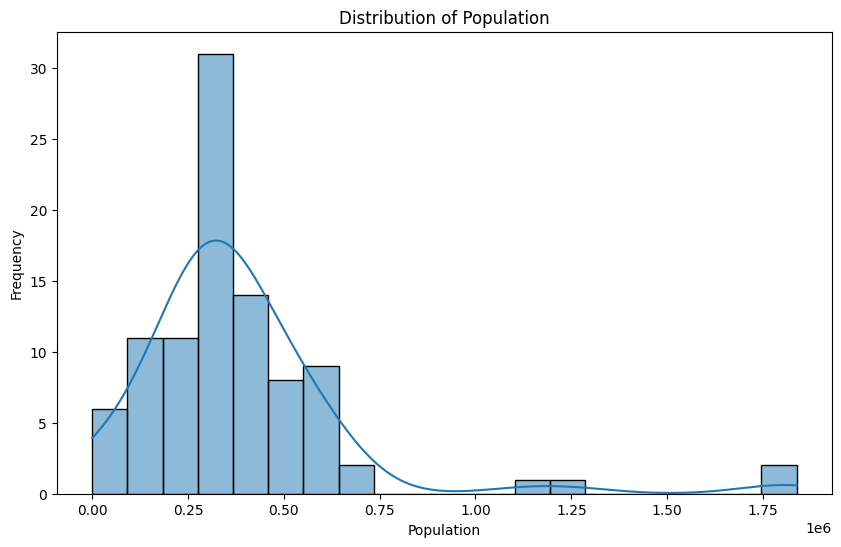

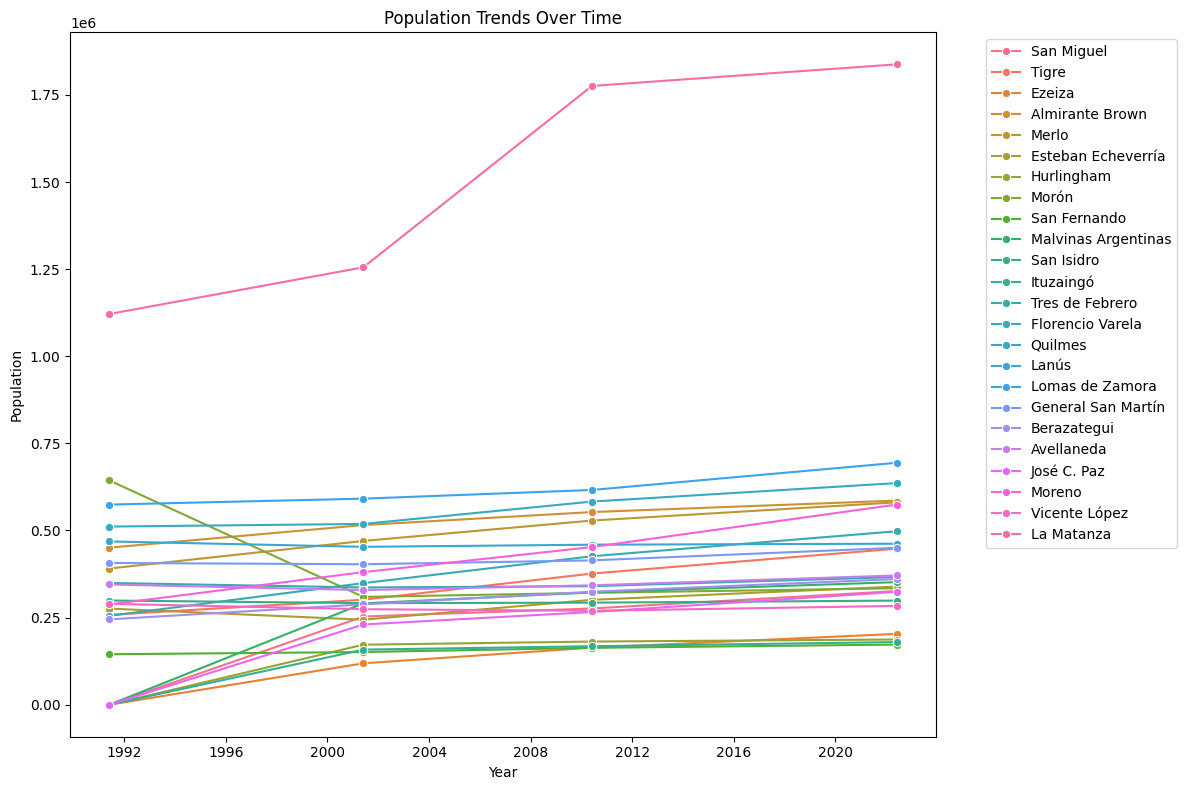

In [8]:


# Create the date column
df['date'] = '06-01-' + df['anio'].astype(str)

# Convert the date column to datetime format
df['date'] = pd.to_datetime(df['date'], format='%m-%d-%Y')

# Check the first few rows of the dataframe
print(df.head())


# Check for missing values
print(df.isnull().sum())

# Summary statistics
print(df.describe())

# Visualize the distribution of population ('pob')
plt.figure(figsize=(10, 6))
sns.histplot(df['pob'], bins=20, kde=True)
plt.title('Distribution of Population')
plt.xlabel('Population')
plt.ylabel('Frequency')
plt.show()

# Visualize the trends in population over time for different locations
plt.figure(figsize=(12, 8))
sns.lineplot(data=df, x='date', y='pob', hue='nam', marker='o')
plt.title('Population Trends Over Time')
plt.xlabel('Year')
plt.ylabel('Population')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
# Visualize the distribution of 'var' variable
plt.figure(figsize=(10, 6))
plt.hist(df['var'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Variable "var"')
plt.xlabel('var')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

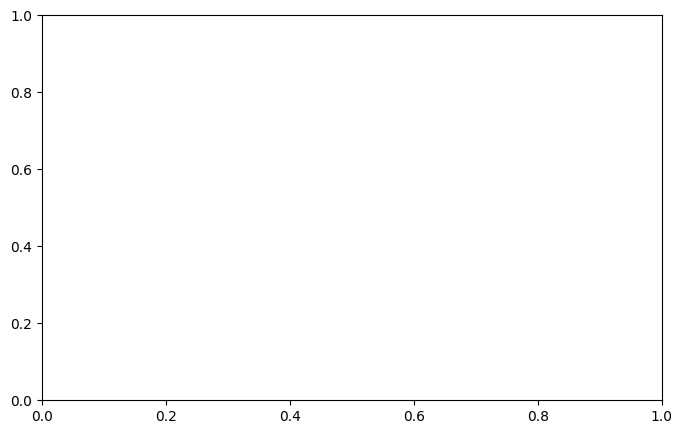

In [10]:

# List of numerical variables
numerical_vars = ['ind_masc', 'dens_pob']
##pob', 'var', 'muj', 'vivpart', 'vivtotal', 'sup',
# Histograms for numerical variables
for var in numerical_vars:
    plt.figure(figsize=(8, 5))
    plt.hist(df[var], bins=20, color='skyblue', edgecolor='black')
    plt.title(f'Distribution of {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Box plots for numerical variables
for var in numerical_vars:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=df[var], color='skyblue')
    plt.title(f'Box Plot of {var}')
    plt.xlabel(var)
    plt.grid(True)
    plt.show()

# Count plots for categorical variables (if any)
categorical_vars = ['nam', 'cod_depto']  # Update with actual categorical variables
for var in categorical_vars:
    plt.figure(figsize=(8, 5))
    sns.countplot(x=var, data=df, palette='pastel')
    plt.title(f'Count Plot of {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()
